<a href="https://colab.research.google.com/github/k99885/Research-Report/blob/master/%EC%83%88%EC%A2%85%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm import tqdm



In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
#Hyperparameter Setting
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}



In [9]:

#Fixed RandomSeed
def seed_everything(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [10]:

#Train & Validation Split
file='/content/drive/MyDrive/dataset/birds'
t_csv='train.csv'
t_csv=os.path.join(file,t_csv)
print(t_csv)
df = pd.read_csv(t_csv)
#train,val 분리
train_set, val_set, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])


/content/drive/MyDrive/dataset/birds/train.csv


In [11]:
print("all:",len(df))
print("train_set:",len(train_set))
print("val_set",len(val_set))


all: 15834
train_set: 11083
val_set 4751


In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# 학습 데이터에 대해 fit_transform 메서드 사용
train_labels_encoded = le.fit_transform(train_set['label'])

# 검증 데이터에 대해 transform 메서드 사용
val_labels_encoded = le.transform(val_set['label'])

# 인코딩된 레이블을 데이터프레임에 할당
train_set['label'] = train_labels_encoded
val_set['label'] = val_labels_encoded

In [13]:
from keras.preprocessing.image import load_img, img_to_array,array_to_img,ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.utils import Sequence

# image_paths = df["img_path"]
# labels = df["label"]


train_image_paths= train_set["img_path"]
train_labels = train_set['label']

val_image_paths= val_set["img_path"]
val_labels = val_set['label']


train_image_paths = train_image_paths.str.replace('./', '')  # "./" 제거
train_full_image_paths = [os.path.join(file, img_path) for img_path in train_image_paths]

val_image_paths = val_image_paths.str.replace('./', '')  # "./" 제거
val_full_image_paths = [os.path.join(file, img_path) for img_path in val_image_paths]



#이미지 데이터 준비
class BirdsDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(64, 64)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        for img_path in batch_paths:
            img = load_img(img_path, target_size=self.target_size)
            #img = img / 255.0  # 이미지를 0~1로 정규화
            img_array = img_to_array(img)
            batch_images.append(img_array)

        batch_images = np.array(batch_images) / 255.0

        return np.array(batch_images), np.array(batch_labels)

In [14]:
batch_size = 20
target_size = (64, 64)
train_data_generator = BirdsDataGenerator(train_full_image_paths, train_labels, batch_size=batch_size, target_size=target_size)
val_data_generator = BirdsDataGenerator(val_full_image_paths, val_labels, batch_size=batch_size, target_size=target_size)


In [15]:
print(len(train_data_generator))
print(len(val_data_generator))

555
238


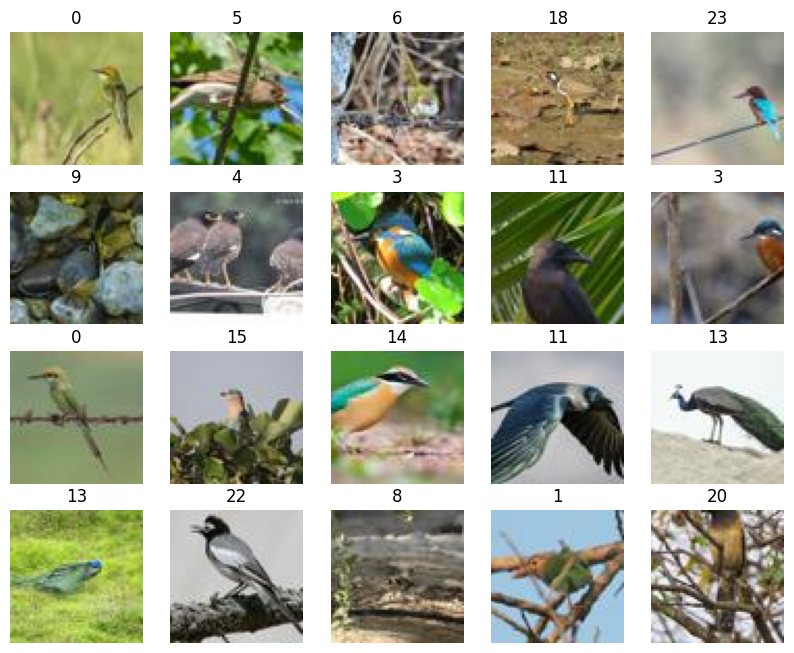

In [ ]:
import matplotlib.pyplot as plt

# 이미지 데이터와 라벨을 가져옵니다.
images, labels = train_data_generator[0]  # 예시로 첫 번째 배치의 이미지 데이터를 가져옵니다.

# 이미지를 시각화합니다.
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    plt.imshow((images[i]*255).astype('uint8'))  # 이미지 데이터는 float32 형식이므로 uint8로 변환하여 표시합니다.
    plt.title(f"{labels[i]}")
    plt.axis('off')  # 축을 제거합니다.
plt.show()


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras import Model

conv_base=VGG16(weights='imagenet',input_shape=(64,64,3),include_top=False)

58889256/58889256 [==============================] - 1s 0us/step


In [17]:
def build_model_with_pretrained(conv_base):
  model=Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(Dense(25,activation='softmax'))

  model.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy',metrics=['acc'])
  return model

In [18]:
model=build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 25)                6425      
                                                                 
Total params: 15245657 (58.16 MB)
Trainable params: 15245657 (58.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
conv_base.trainable=False
model.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy',metrics=['acc'])



In [20]:
train_data_generator[0][0].shape

(20, 64, 64, 3)

In [21]:
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(train_data_generator),
    epochs=20,
    validation_data=val_data_generator,
    validation_steps=len(val_data_generator)
)

Epoch 1/20
344/555 [=================>............] - ETA: 21:52 - loss: 2.5266 - acc: 0.2598

KeyboardInterrupt: 

In [ ]:
model.save('/content/drive/MyDrive/dataset/birds/birds_1')

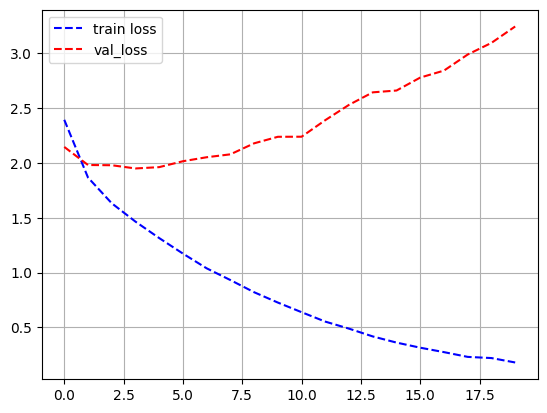

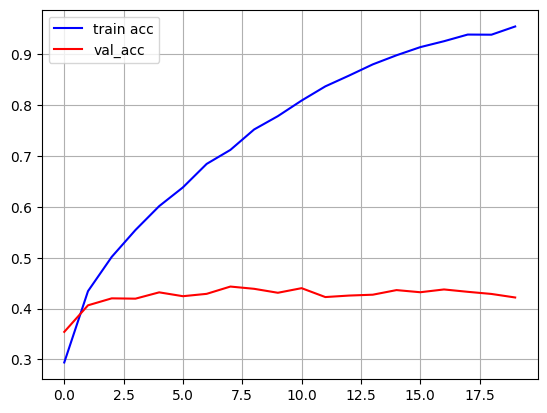

In [19]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))
plt.plot(epochs,loss,'b--',label='train loss')
plt.plot(epochs,val_loss,'r--',label='val_loss')
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs,acc,'b-',label='train acc')
plt.plot(epochs,val_acc,'r-',label='val_acc')
plt.grid()
plt.legend()

plt.show()

In [20]:

#test
file='/content/drive/MyDrive/dataset/birds'
test_csv='test.csv'
test_csv=os.path.join(file,test_csv)
print(test_csv)
test = pd.read_csv(test_csv)



/content/drive/MyDrive/dataset/birds/test.csv


In [21]:
test_image_paths= test["img_path"]
#train_labels = test['label']
test_image_paths = test_image_paths.str.replace('./', '')  # "./" 제거

test_full_image_paths = [os.path.join(file, img_path) for img_path in test_image_paths]

print(test_full_image_paths)

class test_BirdsDataGenerator(Sequence):
    def __init__(self, image_paths, batch_size=32, target_size=(64, 64)):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        for img_path in batch_paths:
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img)
            batch_images.append(img_array)

        batch_images = np.array(batch_images) / 255.0

        return np.array(batch_images)




test_data_generator =test_BirdsDataGenerator(test_full_image_paths, batch_size=32, target_size=(target_size))
print(len(test_data_generator))

['/content/drive/MyDrive/dataset/birds/test/TEST_00000.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00001.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00002.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00003.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00004.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00005.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00006.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00007.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00008.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00009.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00010.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00011.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00012.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00013.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00014.jpg', '/content/drive/MyDrive/dataset/birds/test/TEST_00015.jpg', '/content/drive/MyDrive/dataset/birds/t

In [6]:
loaded_model = tf.keras.models.load_model('birds_1.h5')


OSError: No file or directory found at birds_1.h5

In [1]:
def inference(model, test_generator):
    preds = []
    pred = model.predict(test_generator)
    preds += np.argmax(pred, axis=1).tolist()

    return preds

preds = inference(model, test_data_generator)


NameError: name 'model' is not defined

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = le.inverse_transform(preds)
submit.to_csv('./baseline_submit.csv', index=False)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def train(model, optimizer, train_loader, val_loader, epochs, device):
    best_score = 0
    best_model = None

    for epoch in range(1, epochs + 1):
        train_loss = []
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            with tf.GradientTape() as tape:
                output = model(imgs, training=True)
                loss = tf.keras.losses.sparse_categorical_crossentropy(labels, output)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss.append(loss.numpy())

        train_loss = np.mean(train_loss)
        val_loss, val_score = validation(model, val_loader, device)

        print(f'Epoch [{epoch}], Train Loss : [{train_loss:.5f}], Val Loss : [{val_loss:.5f}], Val F1 Score : [{val_score:.5f}]')

        if val_score > best_score:
            best_score = val_score
            best_model = model

    return best_model

def validation(model, val_loader, device):
    val_loss = []
    preds, true_labels = [], []

    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        output = model(imgs, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, output)

        val_loss.append(loss.numpy())

        preds += np.argmax(output.numpy(), axis=1).tolist()
        true_labels += labels.numpy().tolist()

    val_loss = np.mean(val_loss)
    val_score = f1_score(true_labels, preds, average='macro')

    return val_loss, val_score

In [ ]:
model.fit()

In [ ]:
##Inference
test = pd.read_csv('./test.csv')
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            pred = model(imgs)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()

    preds = le.inverse_transform(preds)
    return preds

preds = inference(infer_model, test_loader, device)


In [ ]:
##Submission
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = preds
submit.to_csv('./baseline_submit.csv', index=False)

--------------------원본코드----------------------------------------------------------------------------------------------------

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#Hyperparameter Setting
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}
#Fixed RandomSeed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정
#Train & Validation Split
df = pd.read_csv('./train.csv')
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])
#Label-Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])
#CustomDataset
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_path_list[index]

        image = cv2.imread(img_path)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)


##Model Define
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
##Train
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    best_score = 0
    best_model = None

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(imgs)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 Score : [{_val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(_val_score)

        if best_score < _val_score:
            best_score = _val_score
            best_model = model

    return best_model
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            pred = model(imgs)

            loss = criterion(pred, labels)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='macro')

    return _val_loss, _val_score
##Run
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)
##Inference
test = pd.read_csv('./test.csv')
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            pred = model(imgs)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()

    preds = le.inverse_transform(preds)
    return preds

preds = inference(infer_model, test_loader, device)
##Submission
submit = pd.read_csv('./sample_submission.csv')
submit['label'] = preds
submit.to_csv('./baseline_submit.csv', index=False)